In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Preproccessing

In [ ]:
# ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter

height, width = 224, 224
batch_size=64


def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255,
                                 rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip = True)

    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='categorical',
        target_size=(height, width),
        # classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

training_dir = '/content/gdrive/My Drive/Colab Notebooks/Dataset/GenderPerson/train/'
validation_dir = '/content/gdrive/My Drive/Colab Notebooks/Dataset/GenderPerson/validation/'

train_generator = generate_data(training_dir)
validation_generator = generate_data(validation_dir)

train_generator.class_indices

Found 308 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


{'Anggun': 0, 'Fadhil': 1, 'Mustamin': 2, 'Tri': 3}

# Build Model

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, CategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.GlobalAveragePooling2D())

model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))

out_gender = tf.keras.layers.Dense(1, activation='sigmoid', name='out_gender')(model_vgg16.output)
out_person = tf.keras.layers.Dense(4, activation='softmax', name='out_person')(model_vgg16.output)

losses = {
    "out_gender": "binary_crossentropy",
    "out_person": "categorical_crossentropy"
}

model = Model(inputs=model_vgg16.input, outputs=[out_gender, out_person])
model.compile(loss=losses,
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vgg16_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['vgg16_input[0][0]']            
                                                                                                  
 global_average_pooling2d (Glob  (None, 512)         0           ['vgg16[0][0]']                  
 alAveragePooling2D)                                                                              
                                                                                              

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='val_out_person_acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

callbacks_list = [checkpoint,early]

history = model.fit(
        train_generator,
        validation_data = validation_generator,
        #steps_per_epoch=10,
        epochs=5,
        shuffle=False,
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/5
5/5 [==============================] - ETA: 0s - loss: 1.6544 - out_gender_loss: 0.5752 - out_person_loss: 1.0792 - out_gender_acc: 0.7500 - out_person_acc: 0.5714 
Epoch 1: val_out_person_acc improved from -inf to 0.68056, saving model to model/vgg16_best.h5
5/5 [==============================] - 106s 23s/step - loss: 1.6544 - out_gender_loss: 0.5752 - out_person_loss: 1.0792 - out_gender_acc: 0.7500 - out_person_acc: 0.5714 - val_loss: 1.5497 - val_out_gender_loss: 0.5662 - val_out_person_loss: 0.9835 - val_out_gender_acc: 0.7500 - val_out_person_acc: 0.6806
Epoch 2/5
5/5 [==============================] - ETA: 0s - loss: 1.5500 - out_gender_loss: 0.5737 - out_person_loss: 0.9763 - out_gender_acc: 0.7500 - out_person_acc: 0.6331 
Epoch 2: val_out_person_acc improved from 0.68056 to 0.80556, saving model to model/vgg16_best.h5
5/5 [==============================] - 91s 19s/step - loss: 1.5500 - out_gender_loss: 0.5737 - out_person_loss: 0.9763 - out_gender_acc: 0.7500 - out_

# Evaluation

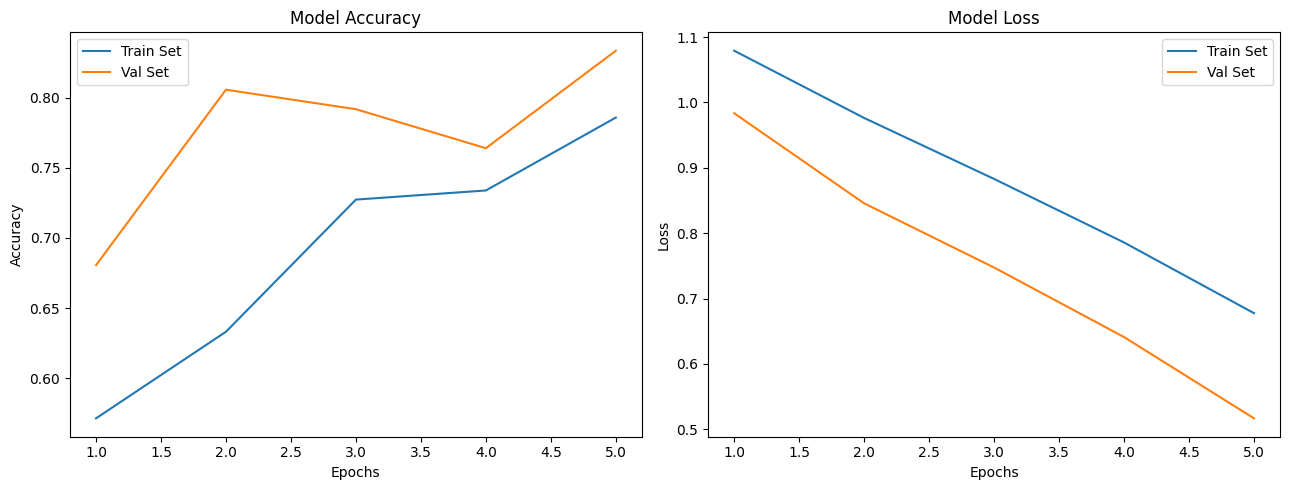

In [ ]:
import matplotlib.pyplot as plt

# plot model performance
acc = history.history['out_person_acc']
val_acc = history.history['val_out_person_acc']
loss = history.history['out_person_loss']
val_loss = history.history['val_out_person_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(13,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# Testing

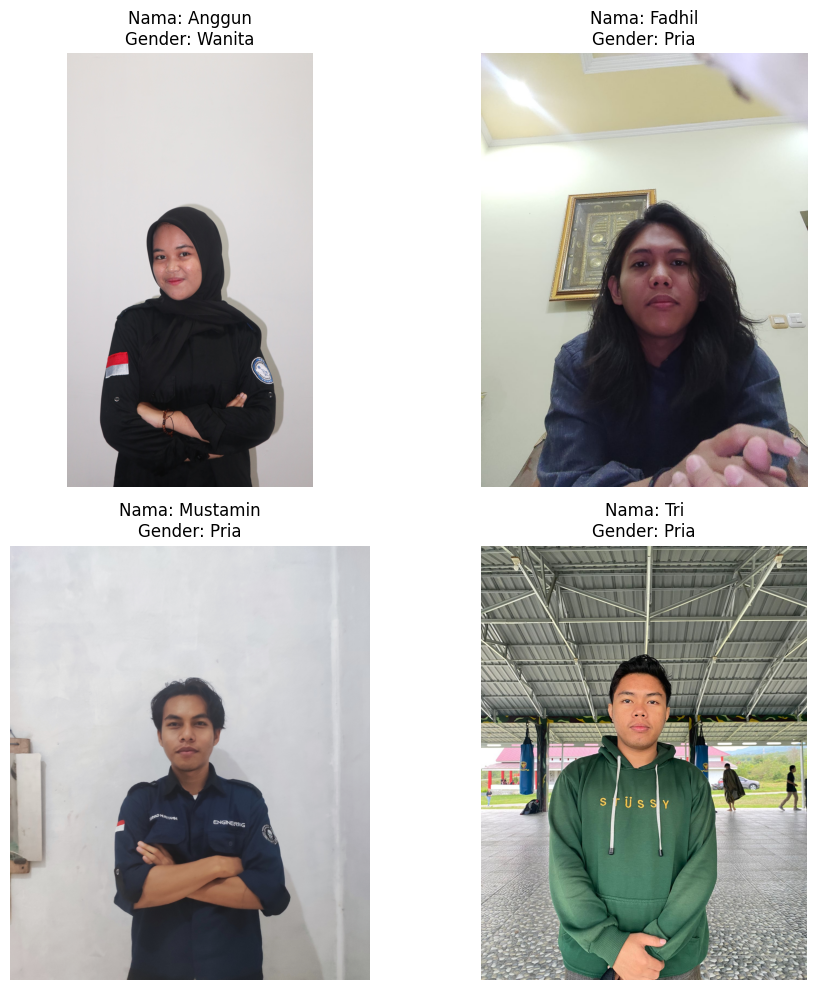

In [ ]:
def predict_image(model, image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (height, width))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    _, gender_pred, person_pred = model.predict(img)

    gender_labels = {0: 'Male', 1: 'Female'}
    person_labels = {0: 'Anggun', 1: 'Fadhil', 2: 'Mustamin', 3: 'Tri'}

    gender_class = np.argmax(gender_pred)
    person_class = np.argmax(person_pred)

    gender = gender_labels[gender_class]
    person = person_labels[person_class]

    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB), gender, person

# Menentukan folder tempat gambar-gambar berada
testing_folder = '/content/gdrive/MyDrive/Colab Notebooks/Dataset/GenderPerson/test'

# Mendapatkan daftar file gambar di folder testing
image_files = os.listdir(testing_folder)

# Membuat subplot
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

# Memuat dan menampilkan gambar-gambar pada subplot
for i in range(4):
    image_path = os.path.join(testing_folder, image_files[i])
    img, gender, person = predict_image(model, image_path)

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Nama: {person}, nGender: {gender}')

# Membersihkan hasil output sebelum menampilkan subplot
plt.clf()
plt.tight_layout()
plt.show()